# Concatenating a gridded rainfall reanalysis dataset into a time series

{opticon}`tag`
{bdg-primary}`General`
{bdg-secondary}`Preprocessing`
{bdg-warning}`Standard`
{bdg-info}`Python`

<p align="left">
    <a href="https://github.com/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/blob/main/LICENSE">
        <img alt="license" src="https://img.shields.io/badge/license-MIT-yellow.svg">
    </a>
    <a href="https://github.com/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/actions/workflows/render.yaml">
        <img alt="render" src="https://github.com/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/actions/workflows/render.yaml/badge.svg">
    </a>
    <a href="https://github.com/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/pull/1">
        <img alt="review" src="https://img.shields.io/badge/view-review-purple">
    </a>
    <br/>
</p>

<p align="left">
    <a href="http://mybinder.org/v2/gh/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://mybinder.org/badge_logo.svg">
    </a>
    <a href="https://replay.notebooks.egi.eu/v2/gh/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://img.shields.io/badge/launch-EGI%20binder-F5A252.svg?logo=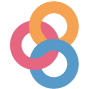">
    </a>
    <br/>
</p>

<p align="left">
    <a href="https://w3id.org/ro-id/ea34568e-d86e-4720-be2f-3f826f66a26c">
        <img alt="RoHub" src="https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue">
    </a>
    <a href="https://zenodo.org/badge/latestdoi/497888281">
        <img alt="doi" src="https://zenodo.org/badge/497888281.svg">
    </a>
</p>

## Context
### Purpose
To load and extract a region of interest from a gridded rainfall reanalysis dataset, and concatenate into a time series using the [Iris package](https://scitools-iris.readthedocs.io/en/stable/).

### Preprocessing description
Time series data allows us to carry out a wide range of analyses including but not limited to trend, seasonality, anomaly detection and causality. As most of the climatological datasets are gridded, we provide a general tool to preprocess them into time series. The example global dataset from NCEP/NCAR reanalysis has a fairly low resolution (T62 Gaussian grid or approximately 1.9 * 1.9 degrees lat/long) which allows easy execution. It is openly available with a variety of atmospheric variables at near surface levels in daily and monthly frequencies as well as long-term monthly mean in NetCDF format, which is described in and can be obtained from the [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html). 

This notebook uses a single sample data file for global daily precipitation rate (monthly mean) included with the notebook.

### Highlights
* Data for the entire globe is loaded and plotted using Iris
* Seasonal means are created by aggregating the data
* The Indonesian Borneo region is extracted and plotted
* The area-averaged time series for Indonesian Borneo region is created 
* A particular season and timeframe are extracted from the time series

### Contributions

#### Notebook
* Timothy Lam (author), University of Exeter, [@timo0thy](https://github.com/timo0thy)
* Marlene Kretschmer (author), University of Reading, [@MarleneKretschmer](https://github.com/MarleneKretschmer)
* Samantha Adams (author), Met Office Informatics Lab, [@svadams](https://github.com/svadams)
* Rachel Prudden (author), Met Office Informatics Lab, [@RPrudden](https://github.com/RPrudden)
* Elena Saggioro (author), University of Reading, [@ESaggioro](https://github.com/ESaggioro)
* Nick Homer (reviewer), University of Edinburgh, [@NHomer](https://github.com/NHomer)
* Alejandro Coca-Castro (reviewer), The Alan Turing Institute, [@acocac](https://github.com/acocac)

#### Dataset originator/creator
* NOAA National Center for Environmental Prediction (creator)

#### Dataset authors
* Eugenia Kalnay, Director, NCEP Environmental Modeling Center

#### Dataset documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "ea34568e-d86e-4720-be2f-3f826f66a26c_dataset"
```

#### Pipeline documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "ea34568e-d86e-4720-be2f-3f826f66a26c_pipeline"
```

:::{note}
NCEP-NCAR Reanalysis 1 data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov
:::

## Load libraries

In [ ]:
import os
import iris
import iris.quickplot as qplt
import iris.coord_categorisation as coord_cat

import cf_units
import nc_time_axis

import matplotlib.pyplot as plt

import urllib.request

import holoviews as hv
import geoviews as gv

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
hv.extension('bokeh')

## Set project structure

In [ ]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Retrieve and/or load a sample data file

In [ ]:
filepath = 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/surface_gauss/'
filename = 'prate.sfc.mon.mean.nc'

if not os.path.exists(os.path.join(notebook_folder,filename)):
    urllib.request.urlretrieve(os.path.join(filepath,filename), os.path.join(notebook_folder, filename))

In [ ]:
# Load monthly precipitation data into an iris cube
precip = iris.load_cube(os.path.join(notebook_folder, filename), 'Monthly Mean of Precipitation Rate')
precip.coord('latitude').guess_bounds()
precip.coord('longitude').guess_bounds()
print(precip)

From `print(precip)` we have an idea whether the metadata is complete and where the possible gaps are. In case the iris cube does not contain a unit, we can set it as follows:

In [ ]:
# Set unit of precipitation data, if the cube does not contain it
unit_to_add = 'kg m-2 s-1'
if precip.units == 'unknown':
    precip.units = cf_units.Unit (unit_to_add)

## Visualisation

Here we use the `Iris quickplot` wrapper to `matplotlib` (static plot with limited interactivity), and `holoviews` to interactive plotting the gridded data with added coastline.

### Static plot

In [ ]:
# Plot data of the first time step using iris quickplot with pcolormesh 
qplt.pcolormesh(precip[0])
plt.gca().coastlines(color='white')
plt.show()

### Interactive plot

In [ ]:
# Declare some options
options = dict(width=600, height=350, yaxis='left', colorbar=True,
               toolbar='above', cmap='viridis', infer_projection=True, tools=['hover'])

# Create a geoviews dataset object
rainfall_ds = gv.Dataset(precip[0], ['longitude', 'latitude'], 'Monthly Mean Of Precipitation Rate (kg m-2 s-1)',
                             group='Monthly mean of precipitation rate')

plot_rainfall = rainfall_ds.to.image().opts(**options) * gv.feature.coastline().opts(line_color='white')
plot_rainfall

## Create seasonal means

Here we construct seasonal means from the monthly data for each grid, for the purpose of extracting a particular season of interest later on.

In [ ]:
# Add auxiliary coordinates to the cube to indicate each season
coord_cat.add_season(precip, 'time', name='clim_season')
coord_cat.add_season_year(precip, 'time', name='season_year')

In [ ]:
print(precip)

In [ ]:
# Aggregate by season
annual_seasonal_mean = precip.aggregated_by(
    ['clim_season', 'season_year'],
    iris.analysis.MEAN)

In [ ]:
# Check this worked
for season, year in zip(
    annual_seasonal_mean.coord('clim_season')[:10].points,
    annual_seasonal_mean.coord('season_year')[:10].points):
    print(season + ' ' + str(year))

## Extract Borneo region

Here we extract our area of study which covers the Indonesian Borneo region, as specified by Melendy et al. (2014) (available at https://daac.ornl.gov/CMS/guides/CMS_LiDAR_Indonesia.html). 

In [ ]:
# Create a constraint for the latitude and Longitude extents
Borneo_lat = iris.Constraint(latitude=lambda v: v > -4.757 and v <= 3.211 )
Borneo_lon = iris.Constraint(longitude=lambda v: v > 107.815 and v <= 117.987 )

# Extract data based on the spatial extent
Borneo =  annual_seasonal_mean.extract(Borneo_lat & Borneo_lon) 
print(Borneo)

In [ ]:
# Plot data of the first season in the study region using iris quickplot with pcolormesh
qplt.pcolormesh(Borneo[0]) 
plt.gca().coastlines(color='white')
plt.show()

## Create area-averaged time series

To construct a seasonal rainfall time series for the study region, we first compute the areal average rainfall. Note that due to the spherical nature of the planet Earth, the area of every grid-box is not the same, therefore we need to perform the weighted mean based on the weights by area.

In [ ]:
# Create area-weights array
grid_area_weights = iris.analysis.cartography.area_weights(Borneo)

# Perform the area-weighted mean using the computed grid-box areas.
Borneo_mean = Borneo.collapsed(['latitude', 'longitude'],
                                iris.analysis.MEAN,
                                weights=grid_area_weights)

We then extract the temporal timescale of interest (Boreal Summers from 1950 - 2019).

In [ ]:
jja_constraint = iris.Constraint(clim_season='jja')
year_constraint = iris.Constraint(season_year=lambda v: v > 1949 and v <= 2019 )

Borneo_jja = Borneo_mean.extract(jja_constraint & year_constraint)
print(Borneo_jja)

Finally, we use the `Iris quickplot` wrapper to `matplotlib pyplot` (static with limited interactivity) and `holoviews` to interactive plotting the time series generated.

### Static plot

In [ ]:
# Plot time series using iris quickplot
qplt.plot(Borneo_jja)
plt.title('Borneo JJA Precipitation')
plt.show()

### Interactive plot

In [ ]:
# As holoviews does not support direct plotting of a non-gridded cube object, we need to decompose the cube into its x- and y-axes.
time = Borneo_jja.coord('season_year').points
data = Borneo_jja.data

# Create a holoviews time series object
Borneo_jja_dynamic = hv.Curve((time, data), 'Time', 'Monthly Mean Of Precipitation Rate (kg m-2 s-1)')

# Show the plot and declare some options
plot_timeseries = Borneo_jja_dynamic.opts(width=600, height=350, yaxis='left', tools=['hover'], title="Borneo JJA Precipitation")
plot_timeseries

### Save as a new NetCDF file

In [ ]:
iris.save(Borneo_jja, os.path.join(notebook_folder, 'Borneo_precip_mean.nc'))

## Summary

This notebook has demonstrated the use of the `Iris` package to easily load, plot and manipulate gridded environmental NetCDF data.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book-gallery/ea34568e-d86e-4720-be2f-3f826f66a26c/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date

print('Notebook repository version: v1.0.2')
print(f'Last tested: {date.today()}')

## Outputs registration
The cell below is dedicated to save the notebook outputs for registering them into a [Zenodo repository](https://zenodo.org/communities/the-environmental-ds-community/?page=1&size=20) curated by the Environmental DS book.

In [ ]:
outputs = {
    'interactive_figures_hvplot': {
        'filenames': ['interactive_map', 'interactive_timeseries'],
        'data':[plot_rainfall, plot_timeseries]},
}

#save holoviews interactive figures
if len(outputs['interactive_figures_hvplot']['filenames']) > 0:
    [hv.save(data, os.path.join(notebook_folder,outputs['interactive_figures_hvplot']['filenames'][x]  + '.html')) for x, data in enumerate(outputs['interactive_figures_hvplot']['data'])]